# Beginning

In [118]:

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import itertools
from scipy.optimize import minimize_scalar

#from scipy.integrate import quad
from JupyROOT import helpers

import ROOT
from JupyROOT.helpers import utils
ROOT.EnableImplicitMT()

# Setting up file upload

In [119]:

file_amount = [4]
i=0
file_temps = {
   "1": ("p{i}.root", file_amount[0]),
   #"2": ("file_name_1{i}.root", file_amount[1]),
   #"3": ("file_name_1{i}.root", file_amount[2]),
}


# proceeding the data mainly in batches of 3 files
base_path = "/home/yuni/informatics_python/data" 

total_files = sum(file_amount)
batch_size = 2
total_batches = (total_files + batch_size - 1) // batch_size  # ceiling 
print(f"Total files: {total_files}, Total batches: {total_batches}")


Total files: 4, Total batches: 2


# File batching function

In [120]:

def get_files_for_batch(batch_index, batch_size):
    chain = ROOT.TChain('adc64_data')
    files_added = 0
    start_file = batch_index * batch_size
    
    if start_file < file_amount[0]:  
        end_file = min(start_file + batch_size, 4)  
        for i in range(start_file, end_file):
            pattern = file_temps["1"][0]
            chain.Add(f"{base_path}/{pattern.format(i=i)}") 
            files_added += 1
        file_name = f"p{batch_index}"    
            
    # remaining_in_batch = batch_size - files_added
    # if remaining_in_batch > 0:
    #     start_file_set2 = max(0, start_file - 4)
        
    #     # set 2
    #     if start_file_set2 < 238:
    #         end_file_set2 = min(start_file_set2 + remaining_in_batch, 238)
    #         for i in range(start_file_set2, end_file_set2):
    #             pattern = file_temps["2"][0]
    #             chain.Add(f"{base_path}{pattern.format(i=i)}")
    #             files_added += 1

    #         file_name = f"p{batch_index}"
                
    # remaining_in_batch = batch_size - files_added
    # if remaining_in_batch > 0:
    #     start_file_set3 = max(0, start_file - 4 - 238)
        
    #     # set 3
    #     if start_file_set3 < 271:
    #         end_file_set3 = min(start_file_set3 + remaining_in_batch, 271)
    #         for i in range(start_file_set3, end_file_set3):
    #             pattern = file_temps["3"][0]
    #             chain.Add(f"{base_path}{pattern.format(i=i)}")
    #             files_added += 1


    #         file_name = f"p{batch_index}"    

            
                
    return chain, files_added, file_name

In [121]:
def total_function(x, const = 1, coef_lin = 0.5, ampl = 0, mean_value = 0.25, sigma_ch = 0.1):
    """The complete fitted function (for minimization)"""
    gaussian = ampl * np.exp(-0.5 * ((x - mean_value) / sigma_ch)**2)
    linear = const + coef_lin * x
    return -(linear + gaussian)  # negative since we need maximum

# Main cycle

batch 0: 2 files
200002 entries
p0 data/pdfs/p0.pdf
GAGG2 PARAMETERS
Background: 32.53 + -0.000028*x
Gaussian amplitude: 43.66
Gaussian mean: 890667.05
Gaussian sigma: 104582.05
Resolution: 27.65%

GAGG1 PARAMETERS
Background: 597.19 + -0.000544*x
Gaussian mean: 1347052.02
Gaussian sigma: 139995.14
Resolution: 24.47%
GaGG 2
Background: 23.38 + -0.088048*x
Gaussian mean: 169.47
Gaussian sigma: 19.29
Resolution: 26.8%

GaGG 1
Background: -327.04 + 0.793722*x
Gaussian mean: 335.88
Gaussian sigma: 34.98
Resolution: 24.53%
Mean G2 + Mean G1: 505.35062446709367
batch 1: 2 files
200002 entries
p1 data/pdfs/p1.pdf
GAGG2 PARAMETERS
Background: 66.90 + -0.000050*x
Gaussian amplitude: 33.35
Gaussian mean: 942900.50
Gaussian sigma: 62652.13
Resolution: 15.65%

GAGG1 PARAMETERS
Background: 34.36 + -0.000001*x
Gaussian mean: 1351804.06
Gaussian sigma: 30000.07
Resolution: 5.23%
GaGG 2
Background: 54.59 + -0.242000*x
Gaussian mean: 170.08
Gaussian sigma: 13.80
Resolution: 19.11%

GaGG 1
Background: 9

Info in <TCanvas::Print>: pdf file /home/yuni/informatics_python/project/pdfs/p0.pdf has been created using the current canvas
Info in <TCanvas::Print>: Current canvas added to pdf file /home/yuni/informatics_python/project/pdfs/p0.pdf and file closed
Info in <TCanvas::Print>: pdf file /home/yuni/informatics_python/project/pdfs/p1.pdf has been created using the current canvas
Info in <TCanvas::Print>: Current canvas added to pdf file /home/yuni/informatics_python/project/pdfs/p1.pdf and file closed


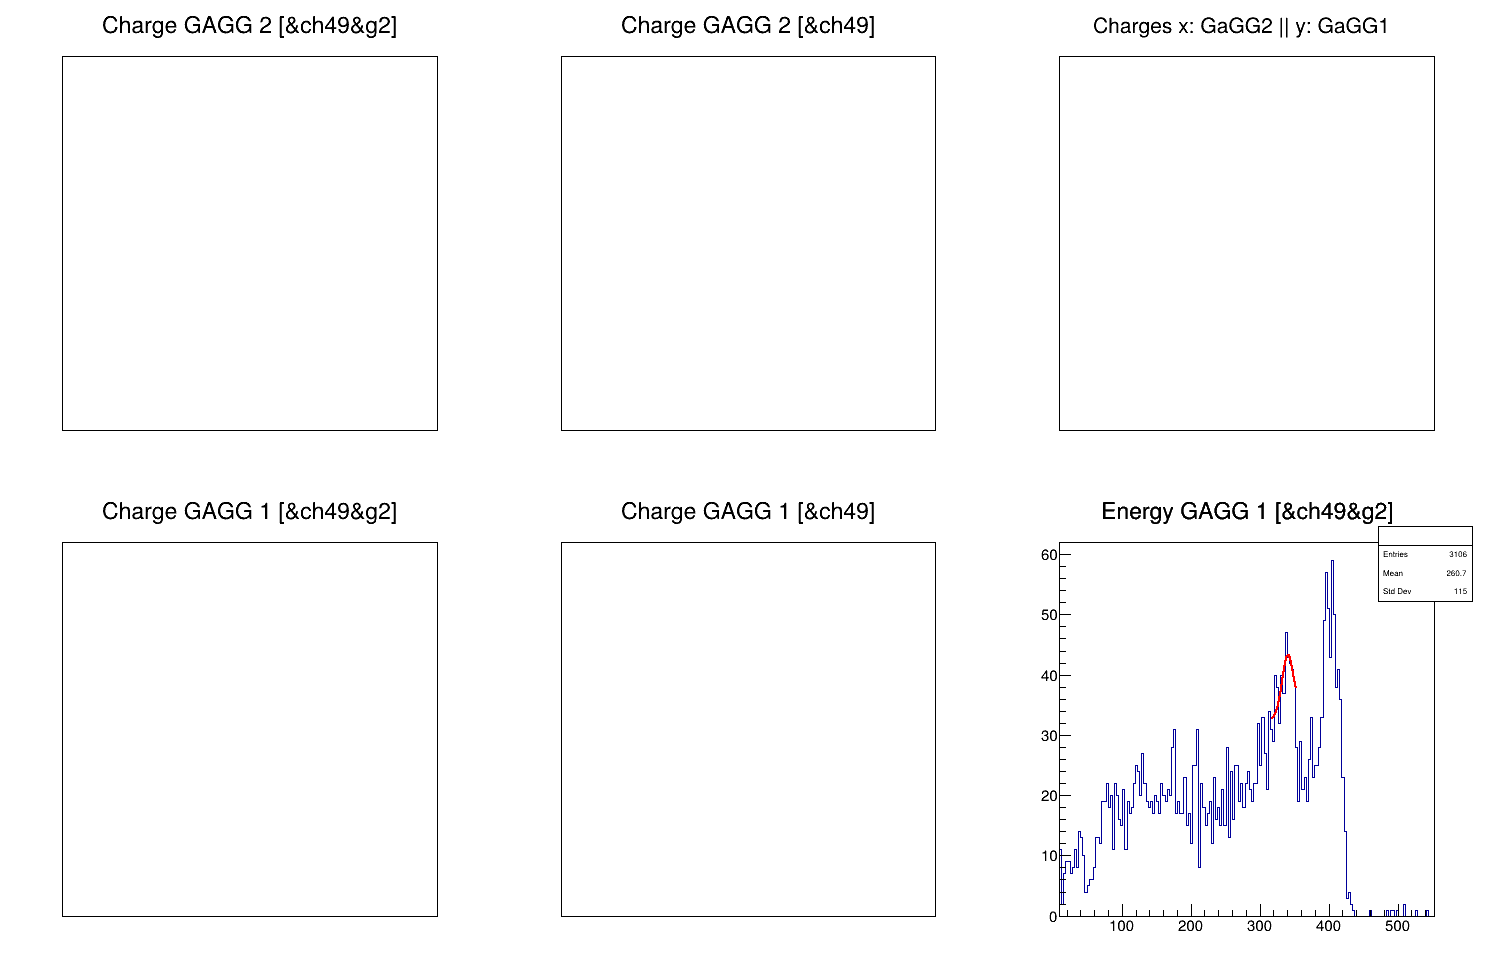

In [ ]:
# main processing loop
for batch_index in range(total_batches):


    chain, files_in_batch, file_name = get_files_for_batch(batch_index, batch_size)
    

    print(f"batch {batch_index}: {files_in_batch} files")
    print(f"{chain.GetEntries()} entries")


    checking = "data/pdfs/" + file_name + ".pdf"
    print(file_name, checking)
    
    file_name_root = "/home/yuni/informatics_python/project/roots/" +  file_name + ".root"
    file_name_pdf = "/home/yuni/informatics_python/project/pdfs/" + file_name + ".pdf"

    
    df = ROOT.RDataFrame(chain)
    df.Count().GetValue()



    # # GaGG #2 calibration 

    df_unaltered = df

    calibration_gagg2_energy = 170.33
    calibration_gagg1_energy = 511 - 170.33

    cuts_gaggs = {}

    # %%
    # Time cut for scatterer   df_timecut_gagg -> df_scat_timecut
    df_time_check = df_unaltered

    # scat1 & scat2
    df_time_check = df_time_check.Define('time_differ_50_49', "channel_50.time - channel_49.time")
    h_scat = df_time_check.Filter('channel_50.charge>1000').Filter('channel_49.charge>1000').Histo1D(('','Plastic scatterers time difference', 200, -2000, 2000), 'time_differ_50_49')


    # scat1 & gagg1
    df_time_check = df_time_check.Define('time_differ_51_49', "channel_51.time - channel_49.time")
    h_scat_g1 = df_time_check.Filter('channel_51.charge>1000').Filter('channel_49.charge>1000').Histo1D(('','First plastic and GaGG1 time difference', 200, -2000, 2000), 'time_differ_51_49')

    # scat2 & gagg1
    df_time_check = df_time_check.Define('time_differ_52_49', "channel_52.time - channel_49.time")
    h_scat_g2 = df_time_check.Filter('channel_52.charge>1000').Filter('channel_49.charge>1000').Histo1D(('','First plastic and GaGG2 time difference', 200, -2000, 2000), 'time_differ_52_49')




    cuts_gaggs["scats"] = "channel_50.time - channel_49.time > -200 && channel_50.time - channel_49.time < 200 "
    cuts_gaggs["scat_g1"] = "channel_51.time - channel_49.time > 100 && channel_51.time - channel_49.time < 300"
    cuts_gaggs["scat_g2"] = "channel_52.time - channel_49.time > 100 && channel_52.time - channel_49.time < 300"

    # gagg2 [front one]

    h_energy_gagg2 = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Histo1D(('', 'Charge GAGG 2 [&ch49]', 120, 10, 2200000), 'channel_52.charge') #df_g2_cut
    h_energy_gagg2_cut = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Filter(cuts_gaggs["scat_g1"]).Histo1D(('', 'Charge GAGG 2 [&ch49&g2]', 120, 10, 2200000), 'channel_52.charge')
    h_energy_gagg1_gagg2_2d = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Histo2D(('hg1g2', 'Charges x: GaGG2 || y: gagg1', 200, 10, 2200000, 200, 10, 2200000),  "channel_52.charge", "channel_51.charge")

    # 2D Histo lines
    lines3 = (
        ROOT.TLine(0, 1500000, 1800000,1500000),
        ROOT.TLine(1800000, 0, 1800000,1500000),
    )
    lines3[0].SetLineColor(ROOT.kRed)
    lines3[1].SetLineColor(ROOT.kRed)
    lines3[0].SetLineWidth(3)
    lines3[1].SetLineWidth(3)

    # fitting gagg2 peak with linear + Gaussian

    # [0] = constant term (b)
    # [1] = slope (a) 
    # [2] = Gaussian amplitude
    # [3] = Gaussian mean
    # [4] = Gaussian sigma

    k = 2.25
    lb, lr = 650000, 1200000

    f_ch_g2 = ROOT.TF1('linear_gaus_fit_g1', '[0] + [1]*x + [2]*exp(-0.5*((x-[3])/[4])**2)', lb, lr)


    f_ch_g2.SetParameter(0, 80)    # constant background
    f_ch_g2.SetParameter(1, 0.0001) # small slope

    h_energy_gagg2_cut.SetAxisRange(lb, lr)
    f_ch_g2.SetParameter(2, h_energy_gagg2_cut.GetMaximum())   # amplitude
    h_energy_gagg2_cut.SetAxisRange(10, 2200000)

    f_ch_g2.SetParameter(3, 890000) #  mean 
    f_ch_g2.SetParameter(4, 75000)  #  sigma

    f_ch_g2.SetParLimits(2, 0, 100000)    
    f_ch_g2.SetParLimits(4, 1000, 200000) 

    h_energy_gagg2_cut.Fit(f_ch_g2, 'q', '', lb, lr)
    h_energy_gagg2_cut.Fit(f_ch_g2, 'q', '', f_ch_g2.GetParameter(3)-k*f_ch_g2.GetParameter(4), f_ch_g2.GetParameter(3)+k*f_ch_g2.GetParameter(4))

    lines2 = (
        ROOT.TLine(f_ch_g2.GetParameter(3)-k*f_ch_g2.GetParameter(4), 0, f_ch_g2.GetParameter(3)-k*f_ch_g2.GetParameter(4), h_energy_gagg2_cut.GetMaximum()),
        ROOT.TLine(f_ch_g2.GetParameter(3)+k*f_ch_g2.GetParameter(4), 0, f_ch_g2.GetParameter(3)+k*f_ch_g2.GetParameter(4), h_energy_gagg2_cut.GetMaximum())
    )






    # gagg1 [back one] 

    h_energy_gagg1 = df_unaltered.Filter(cuts_gaggs["scat_g1"]).Histo1D(('', 'Charge GAGG 1 [&ch49]', 120, 10, 2200000), 'channel_51.charge') 
    h_energy_gagg1_cut = df_unaltered.Filter("channel_51.amp < 61000").Filter(cuts_gaggs["scat_g2"]).Filter(cuts_gaggs["scat_g1"]).Histo1D(('', 'Charge GAGG 1 [&ch49&g2]', 180, 10, 2200000), 'channel_51.charge') # binning was 80
    h_energy_gagg1_gagg2_2d = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Histo2D(('hg1g2', 'Charges x: GaGG2 || y: GaGG1', 200, 10, 2200000, 200, 10, 2200000),  "channel_52.charge", "channel_51.charge")

    # 2D Histo lines
    lines3 = (
        ROOT.TLine(0, 1500000, 1800000,1500000),
        ROOT.TLine(1800000, 0, 1800000,1500000),
    )
    lines3[0].SetLineColor(ROOT.kRed)
    lines3[1].SetLineColor(ROOT.kRed)
    lines3[0].SetLineWidth(3)
    lines3[1].SetLineWidth(3)

    # fitting GaGG1 peak with linear + Gaussian

    # [0] = constant term (b)
    # [1] = slope (a) 
    # [2] = Gaussian amplitude
    # [3] = Gaussian mean
    # [4] = Gaussian sigma

    k = 1.5
    
    
    lb, lr = 1150000, 1500000


    f_ch_g1 = ROOT.TF1('linear_gaus_fit_g1', '[0] + [1]*x + [2]*exp(-0.5*((x-[3])/[4])**2)', lb, lr)


    f_ch_g1.SetParameter(0, 80)    # constant background
    f_ch_g1.SetParameter(1, 0.0001) # small slope

    h_energy_gagg1_cut.SetAxisRange(lb, lr)
    f_ch_g1.SetParameter(2, h_energy_gagg1_cut.GetMaximum())   # amplitude
    h_energy_gagg1_cut.SetAxisRange(10, 2200000)

    f_ch_g1.SetParameter(3, 1300000) #  mean 
    f_ch_g1.SetParameter(4, 100000)  #  sigma

    f_ch_g1.SetParLimits(4, 30000, 140000) #  sigma
    f_ch_g1.SetParLimits(3, 900000, 1450000) #  mean 


    h_energy_gagg1_cut.Fit(f_ch_g1, 'q', '', lb-1000000, lr)
    h_energy_gagg1_cut.Fit(f_ch_g1, 'q', '', f_ch_g1.GetParameter(3)-k*f_ch_g1.GetParameter(4), f_ch_g1.GetParameter(3)+k*f_ch_g1.GetParameter(4))

    lines1 = (
        ROOT.TLine(f_ch_g1.GetParameter(3)-k*f_ch_g1.GetParameter(4), 0, f_ch_g1.GetParameter(3)-k*f_ch_g1.GetParameter(4), h_energy_gagg1_cut.GetMaximum()),
        ROOT.TLine(f_ch_g1.GetParameter(3)+k*f_ch_g1.GetParameter(4), 0, f_ch_g1.GetParameter(3)+k*f_ch_g1.GetParameter(4), h_energy_gagg1_cut.GetMaximum())
    )


    const = f_ch_g1.GetParameter(0)
    coef_lin = f_ch_g1.GetParameter(1)  
    ampl = f_ch_g1.GetParameter(2)
    mean_value = f_ch_g1.GetParameter(3)
    sigma_ch = f_ch_g1.GetParameter(4)




    result = minimize_scalar(
        lambda x: total_function(x, const, coef_lin, ampl, mean_value, sigma_ch),
        bounds=(f_ch_g1.GetParameter(3)-50000, f_ch_g1.GetParameter(3)+50000), 
        method='bounded'
        )


    gagg1_mean = result.x






    # canvas 
    c_charge_together = ROOT.TCanvas('','',500*3,500*2)
    c_charge_together.Divide(3, 2)

    c_charge_together.cd(1); h_energy_gagg2_cut.Draw(); lines2[0].Draw(); lines2[1].Draw()
    c_charge_together.cd(2); h_energy_gagg2.Draw()#; lines1[0].Draw(); lines1[1].Draw()
    c_charge_together.cd(3); h_energy_gagg1_gagg2_2d.Draw()#; lines3[0].Draw(); lines3[1].Draw()
    c_charge_together.cd(4); h_energy_gagg1_cut.Draw(); lines1[0].Draw(); lines1[1].Draw()
    c_charge_together.cd(5); h_energy_gagg1.Draw()#; lines1[0].Draw(); lines1[1].Draw()
    c_charge_together.cd(6); h_energy_gagg1_gagg2_2d.Draw(); lines3[0].Draw(); lines3[1].Draw()

    #c_charge_together.Draw()



    # printing
    print("GAGG2 PARAMETERS")

    res_gagg2 = round(2.355*f_ch_g2.GetParameter(4)/f_ch_g2.GetParameter(3)*100, 2)
    print(f"Background: {f_ch_g2.GetParameter(0):.2f} + {f_ch_g2.GetParameter(1):.6f}*x")
    print(f"Gaussian amplitude: {f_ch_g2.GetParameter(2):.2f}")
    print(f"Gaussian mean: {f_ch_g2.GetParameter(3):.2f}")
    print(f"Gaussian sigma: {f_ch_g2.GetParameter(4):.2f}")
    print(f"Resolution: {res_gagg2}%")

    # printing
    print("\nGAGG1 PARAMETERS")

    res_gagg1 = round(2.355*f_ch_g1.GetParameter(4)/gagg1_mean*100, 2)
    print(f"Background: {f_ch_g1.GetParameter(0):.2f} + {f_ch_g1.GetParameter(1):.6f}*x")
    print(f"Gaussian mean: {gagg1_mean:.2f}")
    print(f"Gaussian sigma: {f_ch_g1.GetParameter(4):.2f}")
    print(f"Resolution: {res_gagg1}%")


    c_charge_together.Print(f"{file_name_pdf}(")



# GaGG2 calibration

    g2_calib = calibration_gagg2_energy/f_ch_g2.GetParameter(3)
    g1_calib = calibration_gagg1_energy/gagg1_mean




    df_unaltered = df_unaltered.Define("g2_en_cal",f"1.*channel_52.charge * {g2_calib}")
    df_unaltered = df_unaltered.Define("g1_en_cal",f"1.*channel_51.charge * {g1_calib}")

    # Calibrated energies below

    # gagg2 [front one]

    h_energy_gagg2 = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Histo1D(('', 'Energy GAGG 2 [&ch49]', 120, 10, 500), 'g2_en_cal') #df_g2_cut
    h_energy_gagg2_cut = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Filter(cuts_gaggs["scat_g1"]).Histo1D(('', 'Energy GAGG 2 [&ch49&g1]', 160, 10, 500), 'g2_en_cal')
    h_energy_gagg1_gagg2_2d = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Histo2D(('hg1g2', 'Energy x: GaGG2 || y: GaGG1', 200, 10, 500, 200, 10, 500),  "g2_en_cal", "g1_en_cal")

    # 2D Histo lines
    lines3 = (
        ROOT.TLine(0, 375, 400,375),
        ROOT.TLine(400, 0, 400,375),
    )
    lines3[0].SetLineColor(ROOT.kRed)
    lines3[1].SetLineColor(ROOT.kRed)
    lines3[0].SetLineWidth(3)
    lines3[1].SetLineWidth(3)

    # fitting gagg2 peak with linear + Gaussian


    # [0] = constant term (b)
    # [1] = slope (a) 
    # [2] = Gaussian amplitude
    # [3] = Gaussian mean
    # [4] = Gaussian sigma

    k = 2.25
    lb, lr = 140,220

    f_en_g2 = ROOT.TF1('linear_gaus_fit_g1', '[0] + [1]*x + [2]*exp(-0.5*((x-[3])/[4])**2)', lb, lr)


    f_en_g2.SetParameter(0, 80)    # constant background
    f_en_g2.SetParameter(1, 0.00001) # small slope

    h_energy_gagg2_cut.SetAxisRange(lb, lr)
    f_en_g2.SetParameter(2, h_energy_gagg2_cut.GetMaximum())   # amplitude
    h_energy_gagg2_cut.SetAxisRange(0, 500)

    f_en_g2.SetParameter(3, 171) #  mean 
    f_en_g2.SetParameter(4, 25)  #  sigma

    f_en_g2.SetParLimits(4, 1, 150) 

    h_energy_gagg2_cut.Fit(f_en_g2, 'q', '', lb, lr)
    h_energy_gagg2_cut.Fit(f_en_g2, 'q', '', f_en_g2.GetParameter(3)-k*f_en_g2.GetParameter(4), f_en_g2.GetParameter(3)+k*f_en_g2.GetParameter(4))

    lines2 = (
        ROOT.TLine(f_en_g2.GetParameter(3)-k*f_en_g2.GetParameter(4), 0, f_en_g2.GetParameter(3)-k*f_en_g2.GetParameter(4), h_energy_gagg2_cut.GetMaximum()),
        ROOT.TLine(f_en_g2.GetParameter(3)+k*f_en_g2.GetParameter(4), 0, f_en_g2.GetParameter(3)+k*f_en_g2.GetParameter(4), h_energy_gagg2_cut.GetMaximum())
    )


 

    # gagg1 [back one]

    h_energy_gagg1 = df_unaltered.Filter(cuts_gaggs["scat_g1"]).Histo1D(('', 'Energy GAGG 1 [&ch49]', 120, 15, 500), 'g1_en_cal') #df_g1_cut
    h_energy_gagg1_cut = df_unaltered.Filter(cuts_gaggs["scat_g2"]).Filter(cuts_gaggs["scat_g1"]).Histo1D(('', 'Energy GAGG 1 [&ch49&g2]', 180, 0.1, 550), 'g1_en_cal')
    h_energy_gagg1_gagg1_2d = df_unaltered.Filter(cuts_gaggs["scat_g1"]).Histo2D(('hg1g2', 'Energy x: GaGG2 || y: GaGG1', 200, 10, 500, 200, 10, 500),  "g2_en_cal", "g1_en_cal")


    # fitting GaGG1 peak with linear + Gaussian

    # [0] = constant term (b)
    # [1] = slope (a) 
    # [2] = Gaussian amplitude
    # [3] = Gaussian mean
    # [4] = Gaussian sigma

    k = 1.5
    
    
    lb, lr = 287, 375

    # # for weird channels!
    # lb, lr = 800000, 1200000

    f_en_g1 = ROOT.TF1('linear_gaus_fit_g1', '[0] + [1]*x + [2]*exp(-0.5*((x-[3])/[4])**2)', lb, lr)


    f_en_g1.SetParameter(0, 80)    # constant background
    f_en_g1.SetParameter(1, 0.0001) # small slope

    h_energy_gagg1_cut.SetAxisRange(lb, lr)
    f_en_g1.SetParameter(2, h_energy_gagg1_cut.GetMaximum())   # amplitude
    h_energy_gagg1_cut.SetAxisRange(10, 550)

    f_en_g1.SetParameter(3, 340) #  mean 1250000
    f_en_g1.SetParameter(4, 25)  #  sigma

    f_en_g1.SetParLimits(4, 7.5, 35) #  sigma
    f_en_g1.SetParLimits(3, 225, 362) #  mean 


    h_energy_gagg1_cut.Fit(f_en_g1, 'q', '', lb-250, lr)
    h_energy_gagg1_cut.Fit(f_en_g1, 'q', '', f_en_g1.GetParameter(3)-k*f_en_g1.GetParameter(4), f_en_g1.GetParameter(3)+k*f_en_g1.GetParameter(4))

    lines1 = (
        ROOT.TLine(f_en_g1.GetParameter(3)-k*f_en_g1.GetParameter(4), 0, f_en_g1.GetParameter(3)-k*f_en_g1.GetParameter(4), h_energy_gagg1_cut.GetMaximum()),
        ROOT.TLine(f_en_g1.GetParameter(3)+k*f_en_g1.GetParameter(4), 0, f_en_g1.GetParameter(3)+k*f_en_g1.GetParameter(4), h_energy_gagg1_cut.GetMaximum())
    )




    const = f_en_g1.GetParameter(0)
    coef_lin = f_en_g1.GetParameter(1)  
    ampl = f_en_g1.GetParameter(2)
    mean_value = f_en_g1.GetParameter(3)
    sigma_ch = f_en_g1.GetParameter(4)



    result = minimize_scalar(
        lambda x: total_function(x, const, coef_lin, ampl, mean_value, sigma_ch),
        bounds=(f_en_g1.GetParameter(3)-12.5, f_en_g1.GetParameter(3)+12.5), 
        method='bounded'
    )



    gagg1_en_mean = result.x





    # printing
    print("GaGG 2")
    res_gagg2 = round(2.355*f_en_g2.GetParameter(4)/f_en_g2.GetParameter(3)*100, 2)
    print(f"Background: {f_en_g2.GetParameter(0):.2f} + {f_en_g2.GetParameter(1):.6f}*x")
    print(f"Gaussian mean: {f_en_g2.GetParameter(3):.2f}")
    print(f"Gaussian sigma: {f_en_g2.GetParameter(4):.2f}")
    print(f"Resolution: {res_gagg2}%")


    # canvas 
    c_energy_together = ROOT.TCanvas('','',500*3,500*2)
    c_energy_together.Divide(3, 2)

    c_energy_together.cd(1); h_energy_gagg2_cut.Draw(); lines2[0].Draw(); lines2[1].Draw()
    c_energy_together.cd(2); h_energy_gagg2.Draw()#; lines1[0].Draw(); lines1[1].Draw()
    c_energy_together.cd(3); h_energy_gagg1_gagg2_2d.Draw()#; lines3[0].Draw(); lines3[1].Draw()

    #printing
    print("\nGaGG 1")
    res_gagg1 = round(2.355*f_en_g1.GetParameter(4)/gagg1_en_mean*100, 2)
    print(f"Background: {f_en_g1.GetParameter(0):.2f} + {f_en_g1.GetParameter(1):.6f}*x")
    print(f"Gaussian mean: {gagg1_en_mean:.2f}")
    print(f"Gaussian sigma: {f_en_g1.GetParameter(4):.2f}")
    print(f"Resolution: {res_gagg1}%")


    # canvas 

    c_energy_together.cd(4); h_energy_gagg1_cut.Draw(); lines1[0].Draw(); lines1[1].Draw()
    c_energy_together.cd(5); h_energy_gagg1.Draw()#; lines1[0].Draw(); lines1[1].Draw()
    c_energy_together.cd(6); h_energy_gagg1_gagg1_2d.Draw(); lines3[0].Draw(); lines3[1].Draw()

    #c_energy_together.Draw()



    print("Mean G2 + Mean G1:", gagg1_en_mean+f_en_g2.GetParameter(3))





    c_energy_together.Print(f"{file_name_pdf})")